In [1]:
# Import the io module from the pyspots library
from pyspots import io
# Import the numpy library. We shorten it to 'np' for easy of typing later
import numpy as np
# matploblit is the plotting library that we will use to display
# our data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the path to your Ramdog output data that you want to load
path_to_spot_data = '/home/edill/dev/martinlab/pyspots/pyspots/data/spots90FQ2_normalized_spot.dat'
# And load the data into memory
raw_spot_data = io.read_normalized_file(path_to_spot_data)

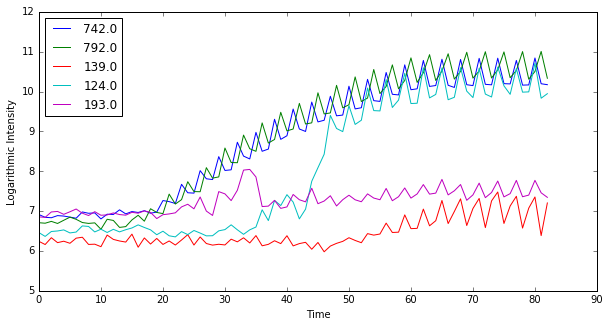

In [3]:
# Plot 5 random spots to make sure it is looking good
import random
# make a matplotlib figure and axes
fig, ax = plt.subplots(figsize=(10, 5))
for _ in range(5):
    spot = random.choice(raw_spot_data)
    # use the 'plot' function on the axes object to 
    # render each spot intensity data set
    ax.plot(range(len(spot.data)), np.log(spot.data), label=spot.idx)

ax.legend(loc=0)
ax.set_xlabel('Time')
ax.set_ylabel('Logarithmic Intensity')

In [4]:
# Take the running average of one of the spots
spot = raw_spot_data[0]
data = np.asarray(spot.data)
averaged_spot_data = (data[1:-1] + data[:-2] + data[2:]) / 3


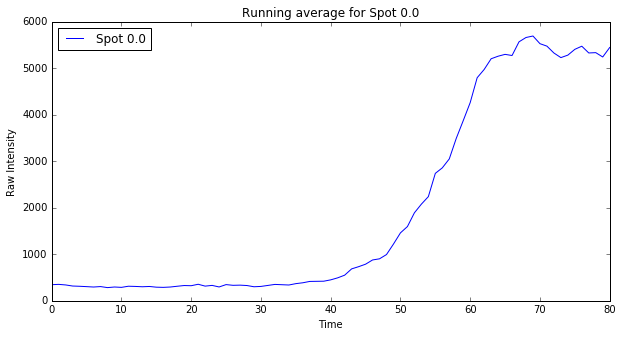

In [5]:
# and plot it to make sure it looks ok
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(averaged_spot_data)), averaged_spot_data, label="Spot %s" % spot.idx)
ax.set_xlabel('Time')
ax.set_ylabel('Raw Intensity')
ax.set_title("Running average for Spot %s" % spot.idx)
# loc=0 tells matplotlib to put the legend in the "best" spot which
# generally means to overlap it with as little of the data as possible
ax.legend(loc=0)

In [6]:
# normalize the data to between 0 and 1
avg_min = np.average(averaged_spot_data[:5])
avg_max = np.average(averaged_spot_data[-5:])

normalized_dataset = (averaged_spot_data - avg_min) / (avg_max - avg_min)

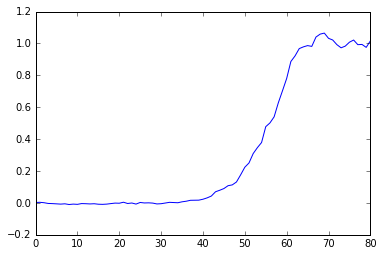

In [7]:
plt.plot(normalized_dataset)

In [8]:
# define our fitting function

def avrami(t, kA, t0, n):
    return 1 - np.exp(-1*((t - t0) * kA) ** n)

# and now we fit it!
from lmfit import Model, Parameters

m = Model(avrami)

# don't allow kA to be zero or negative
m.set_param_hint('kA', min=10**-7)
# fix n to 3
m.set_param_hint('n', value=3, vary=False)

[[Model]]
    Model(avrami)
[[Fit Statistics]]
    # function evals   = 138
    # data points      = 81
    # variables        = 2
    chi-square         = 0.829
    reduced chi-square = 0.010
[[Variables]]
    kA:   0.02656328 +/- 0.000879 (3.31%) (init= 0.1)
    n:    3 (fixed)
    t0:   20.7368931 +/- 1.078181 (5.20%) (init= 30)
[[Correlations]] (unreported correlations are <  0.100)
    C(kA, t0)                    =  0.808 



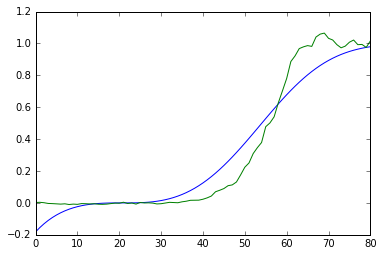

In [9]:
# define our time
time = np.asarray(range(len(normalized_dataset)))
# do the initial fit
fit = m.fit(normalized_dataset, t=time, n=3, kA=0.1, t0=30)

# print the fit results
print(fit.fit_report())

# plot the fit
plt.plot(fit.best_fit)
plt.plot(normalized_dataset)

Ok, so clearly this is not a good fit,  Let's try to fit out experimental data where alpha < 0.5

In [10]:
# find the indices where our experimental data is less than 0.5
less_than_half = normalized_dataset <= 0.5

# Now let's also only grab data that is greater than our t0
after_t0 = time > fit.params['t0']

# Combine the indices
fit_indices = less_than_half & after_t0


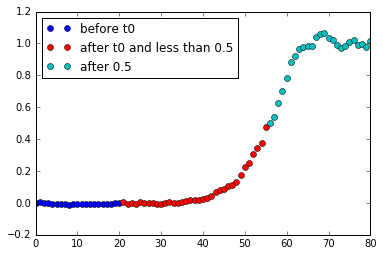

In [11]:
# plot the normalized data
indices = ~after_t0
plt.plot(time[indices], normalized_dataset[indices], 'bo', label='before t0')

# use these indices to extract the time and normalized values where we are 
# less than 0.5 and after t0
indices = less_than_half & after_t0
plt.plot(time[indices], normalized_dataset[indices], 'ro', label='after t0 and less than 0.5')

indices = ~less_than_half
plt.plot(time[indices], normalized_dataset[indices], 'co', label='after 0.5')
# turn on the legend in a good location
plt.legend(loc=0)

In [12]:
# Now let's try to fit with the data that is after t0 and less than 0.5

In [13]:
fit.params.values()

odict_values([<Parameter 'kA', value=0.026563288620402026 +/- 0.000879, bounds=[1e-07:inf]>, <Parameter 'n', value=3 (fixed), bounds=[-inf:inf]>, <Parameter 't0', value=20.736893107473524 +/- 1.08, bounds=[-inf:inf]>])

In [14]:
# define our time
indices = less_than_half & after_t0
new_fit_time = time[indices]
new_fit_data = normalized_dataset[indices]

# do the fit
fit = m.fit(new_fit_data, t=new_fit_time, n=3, kA=0.1, t0=30)

# print the fit results
print(fit.fit_report())

[[Model]]
    Model(avrami)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 35
    # variables        = 2
    chi-square         = 0.012
    reduced chi-square = 0.000
[[Variables]]
    kA:   0.03350216 +/- 0.000982 (2.93%) (init= 0.1)
    n:    3 (fixed)
    t0:   30.8258253 +/- 0.576984 (1.87%) (init= 30)
[[Correlations]] (unreported correlations are <  0.100)
    C(kA, t0)                    =  0.955 



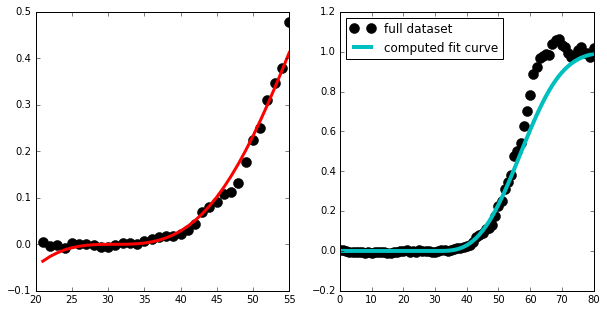

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
# plot the data range that was being fit
ax1.plot(new_fit_time, new_fit_data, 'ko', ms=10, label='fit range')
# plot the fit 
ax1.plot(new_fit_time, fit.best_fit, 'r-', linewidth=3, label='fit range')
# plot the fit against the full dataset

# only compute this for times greater than t0
after_t0 = time > fit.params['t0']
# get the parameters and their values
param_values = {k: v.value for k,v in fit.params.items()}
# compute the full fit
full_fit = avrami(time, **param_values)
# zero out all the values before t0
full_fit[time < fit.params['t0']] = 0
# plot the full data set
ax2.plot(time, normalized_dataset, 'ko', label='full dataset', ms=10)
ax2.plot(time, full_fit, 'c-', label='computed fit curve', linewidth=4)
plt.legend(loc=0)


In [22]:
# Let's create a helper function to plot our data for us, since it is growing into a reasonably 
# large piece of code.
def plot_fit_against_full_dataset(full_time, full_data, fit_time, fit_data, fit, 
                                  title=None, model=avrami):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    ax1.plot(fit_time, fit_data, 'ko', ms=10, label='Data used for fitting')
    ax1.plot(fit_time, fit.best_fit, 'r-', linewidth=3, label='Fit')
    ax1.plot(fit_time, (fit_data - fit.best_fit) - 0.15, 'ko-', linewidth=2, label="Residuals")
    ax1.plot(fit_time, [-0.15] * len(fit_time), 'k--', linewidth=1)
    ax1.legend(loc=0)
    ax1.set_xlabel("Time (arb)")
    ax1.set_ylabel("Normalized Intensity, "r"$\alpha$")
    ax1.set_title('Fit values')
    
    
    # use a dictionary comprehension to extract the values of the parameters
    # compute the model against the time range
    full_model = model(full_time, **fit.best_values)
    # zero out all values before t0
    full_model[full_time < fit.params['t0']] = 0
    ax2.plot(full_time, full_data, 'ko', ms=10, label='Full dataset')
    ax2.plot(full_time, full_model, 'c-', linewidth=3, label='Full fit')
    ax2.plot(full_time, (full_data - full_model) - 0.15, 'ko-', linewidth=2, label="Residuals")
    ax2.plot(full_time, [-0.15] * len(full_time), 'k--', linewidth=1)
    ax2.legend(loc=0)
    ax2.set_xlabel("Time (arb)")
    ax2.set_ylabel("Normalized Intensity, "r"$\alpha$")
    ax2.set_title("Fit against full data set")

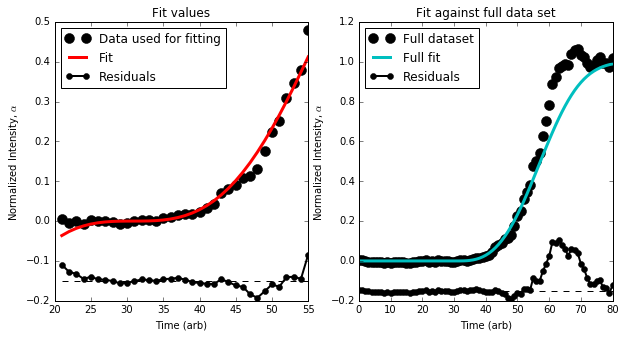

In [23]:
# and let's plot that last result again
plot_fit_against_full_dataset(time, normalized_dataset, new_fit_time, new_fit_data, fit)

In [37]:
# Ok, we should probably just iterate the fit with a mobile t0 until we reach a stable point
def fit_again(starting_params, full_time, normalized_dataset, model):
    # find the indices where our experimental data is less than 0.5
    less_than_half = normalized_dataset <= 0.5

    # Now let's also only grab data that is greater than our t0
    after_t0 = full_time > starting_params['t0']

    # Combine the indices
    fit_indices = less_than_half & after_t0
    
    fit_time = full_time[fit_indices]
    fit_data = normalized_dataset[fit_indices]
    return model.fit(fit_data, **starting_params, t=fit_time), fit_time, fit_data


starting params: {'kA': 0.033502168671266097, 'n': 3, 't0': 30.825825344990399}
final params: {'kA': 0.039336133586221567, 'n': 3, 't0': 33.826772631554299}


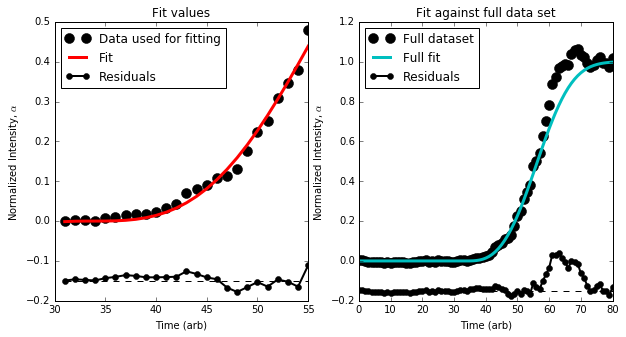

In [48]:
# run the fit with the fit helper
print("starting params: {}".format(fit.best_values))
new_fit, fit_time, fit_data = fit_again(fit.best_values, time, normalized_dataset, m)
print("final params: {}".format(new_fit.best_values))
plot_fit_against_full_dataset(time, normalized_dataset, fit_time, fit_data, new_fit)

starting params: {'kA': 0.039336133586221567, 'n': 3, 't0': 33.826772631554299}
final params: {'kA': 0.039354337789521909, 'n': 3, 't0': 33.834959958995952}


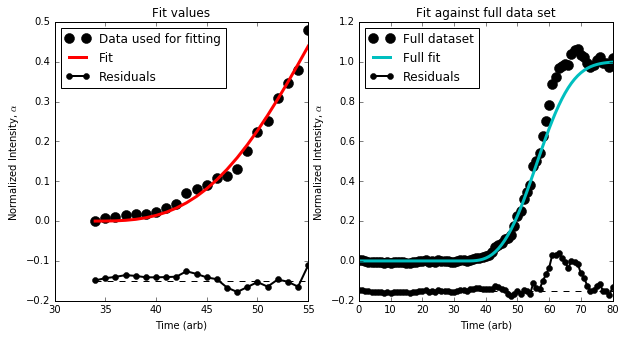

In [49]:
# run the fit again, but this time pass it the output from the last fit
print("starting params: {}".format(new_fit.best_values))
new_fit, fit_time, fit_data = fit_again(new_fit.best_values, time, normalized_dataset, m)
print("final params: {}".format(new_fit.best_values))
plot_fit_against_full_dataset(time, normalized_dataset, fit_time, fit_data, new_fit)

Run it once more using the output of the last fit

starting params: {'kA': 0.039354337789521909, 'n': 3, 't0': 33.834959958995952}
final params: {'kA': 0.039354388665206019, 'n': 3, 't0': 33.834983192761634}


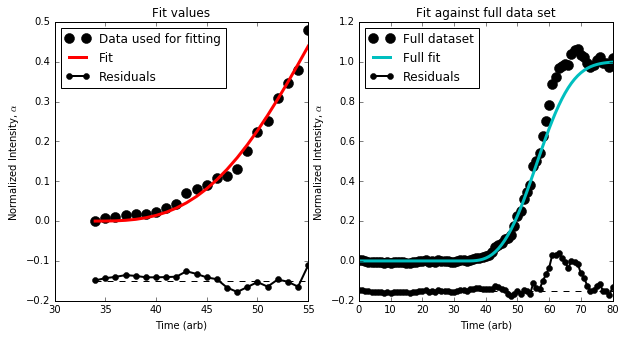

In [50]:
# run the fit again, but this time pass it the output from the last fit
print("starting params: {}".format(new_fit.best_values))
new_fit, fit_time, fit_data = fit_again(new_fit.best_values, time, normalized_dataset, m)
print("final params: {}".format(new_fit.best_values))
plot_fit_against_full_dataset(time, normalized_dataset, fit_time, fit_data, new_fit)

In [ ]:
# Looks like we have reasonably converged on a set of parameters. Nice!